# Using Keras to train MixtureOfSVGPExperts on the Quadcopter Data Set

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using `MixtureOfSVGPExperts`) on the motorcycle data set. It shows how to instantiate the model in the special two expert case when only a single gating function is needed (not two!) and the gating network can be calculated in closed form. It then shows how to save and load the model using Keras. Finally, it shows how to instantiate and train the model in the general case with more that two experts.

In [8]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

from gpflow import default_float
from gpflow.models import SVGP
from gpflow.utilities import print_summary

from mogpe.keras.experts import SVGPExpert
# from mogpe.keras.gps import SVGPPrior
from mogpe.keras.gating_networks import SVGPGatingNetwork
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting.quadcopter_plotter import QuadcopterPlotter
from mogpe.keras.utils import model_from_yaml

Let's start by loading the motorcycle dataset and plotting it to see what we're dealing with.

In [9]:
def load_quadcopter_dataset(filename, trim_coords = None, standardise = True):
    data = np.load(filename)
    X = data["x"]
    Y = data["y"][:, 0:2]
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    if standardise:
        X = (X - X.mean()) / X.std()
        Y = (Y - Y.mean()) / Y.std()

    # remove some data points
    def trim_dataset(X, Y, trim_coords):
        mask_0 = X[:, 0] < trim_coords[0][0]
        mask_1 = X[:, 1] < trim_coords[0][1]
        mask_2 = X[:, 0] > trim_coords[1][0]
        mask_3 = X[:, 1] > trim_coords[1][1]
        mask = mask_0 | mask_1 | mask_2 | mask_3
        return X[mask, :], Y[mask, :]

    X, Y = trim_dataset(X, Y, trim_coords)
    print("Trimmed input data shape: ", X.shape)
    print("Trimmed output data shape: ", Y.shape)

    return X, Y

In [10]:
# data_file = "./quadcopter/data/quadcopter_data_step_10_direction_down.npz"
data_file = "../data/quadcopter_data_step_20_direction_down.npz"
# data_file = "./quadcopter/data/quadcopter_data_step_40_direction_down.npz"
trim_coords = [[-1.5, -3.0], [1.5, 0.0]]
standardise = True  # true/false whether to standardise data
X, Y = load_quadcopter_dataset(filename=data_file, trim_coords=trim_coords, standardise=standardise)

Input data shape:  (1315, 2)
Output data shape:  (1315, 2)
Trimmed input data shape:  (640, 2)
Trimmed output data shape:  (640, 2)


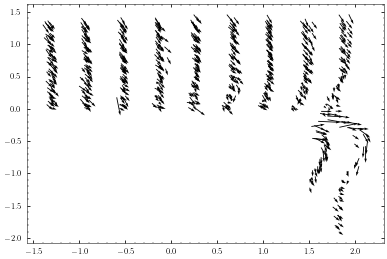

In [11]:
num_data, input_dim = X.shape
output_dim = Y.shape[1]
plt.quiver(X[:, 0], X[:, 1], Y[:, 0], Y[:, 1])

In [12]:
num_experts = 2
# experts_lengthscales = [1.0, 1.0]  # lengthsales for expert 1 and 2
# experts_lengthscales = [1.0, 10.0]  # lengthsales for expert 1 and 2
num_inducing_expert = 80  # number of inducing points for each expert
num_inducing_gating = 100  # number of inducing points for gating network

In order to initialie the `MixtureOfSVGPExperts` class we must pass it a list of `SVGPExpert` instances and an instance of `SVGPGatingNetwork`. Let's start by creating the list of experts. To do this we create a `Likelihood` and `SVGPPrior` for each expert.

In [13]:
def sample_inducing_inputs_from_data(X, num_inducing):
    idx = np.random.choice(range(X.shape[0]), size=num_inducing, replace=False) 
    return X[idx, ...].reshape(-1, input_dim)

def sample_inducing_variable_from_data(X, num_inducing):
    inducing_inputs = sample_inducing_inputs_from_data(X, num_inducing)
    return gpf.inducing_variables.InducingPoints(inducing_inputs)

def init_expert(lengthscales=[1.0, 1.0], kernel_variance=1.0, noise_variance=[1.0]):
    inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(sample_inducing_variable_from_data(X, num_inducing_gating))
    mean_function = gpf.mean_functions.Constant([0.0]*output_dim)
    likelihood = gpf.likelihoods.Gaussian(noise_variance*output_dim)
    kernel_list = [gpf.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance) for _ in range(output_dim)]
    kernel = gpf.kernels.SeparateIndependent(kernel_list)
    return SVGPExpert(kernel, 
                      likelihood=likelihood, 
                      inducing_variable=inducing_variable, 
                      mean_function=mean_function,
                      num_latent_gps=output_dim)

In [14]:
experts_list = [init_expert() for k in range(num_experts)]

Lovely stuff. We now need to create an instance of `SVGPGatingNetwork`. Remember that we only need a single gating function for the two expert case. Let's go ahead and create a single gating function and use it to construct our gating network. The `SVGPGatingNetwork` constructor accepts a `SVGPPrior` instance and uses it to select the right likelihood. It selects the `Bernoulli` likelihood if the `SVGPPrior` has a single output and selects the `Softmax` likelihood in the general case when a multioutput `SVGPPrior` (where each output dimension corresponds to a gating function).

In [15]:
def init_gating_network(num_gating_gps=1):
    if num_gating_gps == 1:
        inducing_variable = sample_inducing_variable_from_data(X, num_inducing_gating)
        kernel = gpf.kernels.RBF()
    else:
        kernel = gpf.kernels.SeparateIndependent([gpf.kernels.RBF() for _ in range(num_gating_gps)])
        inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(sample_inducing_variable_from_data(X, num_inducing_gating))
    return SVGPGatingNetwork(kernel=kernel, mean_function=gpf.mean_functions.Zero(), inducing_variable=inducing_variable)

In [16]:
gating_network = init_gating_network()
# print_summary(gating_network, fmt="notebook")

We now have all the components to construct our `MixtureOfSVGPExperts` model so let's go ahead and do it.

In [17]:
model = MixtureOfSVGPExperts(experts_list=experts_list, 
                             gating_network=gating_network, 
                             num_data=X.shape[0], 
                             num_samples=1,
                             bound="further_gating")
# print_summary(model, fmt="notebook")

We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.  
- The top plot shows mixing probablility for each expert,
- Middle plots show each experts latent GP,
- The bottom plot shows the models posterior with the mean (black line) and samples (green dots).

In [18]:
import palettable
cmap = palettable.scientific.sequential.Bilbao_15.mpl_colormap
figsize = (12, 4)
num_test = 400
factor = 1.2
sqrtN = int(np.sqrt(num_test))
xx = np.linspace(tf.reduce_min(X[:, 0]) * factor, np.max(X[:, 0]) * factor, sqrtN)
yy = np.linspace(tf.reduce_min(X[:, 1]) * factor, np.max(X[:, 1]) * factor, sqrtN)
xx, yy = np.meshgrid(xx, yy)
test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])


def plot_contf(ax, z):
    contf = ax.tricontourf(test_inputs[:, 0], test_inputs[:, 1], z, levels=10, cmap=cmap)
    return contf

def plot_gp(axs, mean, var):
    axs[0].set_title('Mean')
    axs[1].set_title('Variance')
    return plot_contf(axs[0], mean), plot_contf(axs[1], var)

def plot_gating_network(gating_network):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(num_experts, 2, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.suptitle("Gating GPs")
    h_means, h_vars = gating_network.predict_h(test_inputs)
    for k in range(num_experts):
        plot_gp(axs[k, :], h_means[:, k], h_vars[:, k])
    mixing_probs = gating_network.predict_mixing_probs(test_inputs)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Mixing Probabilities")
    gs = fig.add_gridspec(1, num_experts, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    for k in range(num_experts):
        plot_contf(axs[k], mixing_probs[:, k])
        axs[k].set_title('Expert {}'.format(k+1))

def plot_expert(expert, k):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Expert {} Latent Function GPs".format(k+1))
    gs = fig.add_gridspec(output_dim, 2, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    f_means, f_vars = expert.predict_f(test_inputs)
    for j in range(output_dim):
        plot_gp(axs[j,:], f_means[:, j], f_vars[:, j])

def plot_experts(experts_list):
    for k, expert in enumerate(experts_list):
        plot_expert(expert, k)

def plot_model(model):
    plot_gating_network(model.gating_network)
    plot_experts(model.experts_list)

In [40]:
import palettable
from mogpe.custom_types import InputData
from typing import Tuple, Callable, Any, Optional
from dataclasses import dataclass
cmap = palettable.scientific.sequential.Bilbao_15.mpl_colormap
figsize = (12, 4)
num_test = 400
factor = 1.2
sqrtN = int(np.sqrt(num_test))
xx = np.linspace(tf.reduce_min(X[:, 0]) * factor, np.max(X[:, 0]) * factor, sqrtN)
yy = np.linspace(tf.reduce_min(X[:, 1]) * factor, np.max(X[:, 1]) * factor, sqrtN)
xx, yy = np.meshgrid(xx, yy)
test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_contf(ax, z, test_inputs):
    contf = ax.tricontourf(test_inputs[:, 0], test_inputs[:, 1], z, levels=10, cmap=cmap)
    return contf

def plot_gp(axs, mean, var, test_inputs, label=""):
    axs[0].set_title(label+'Mean')
    axs[1].set_title(label+'Variance')
    return plot_contf(axs[0], mean, test_inputs), plot_contf(axs[1], var, test_inputs)

class MixtureOfSVGPExpertsPlotter:
    def __init__(self, 
                 model: MixtureOfSVGPExperts,
                 test_inputs: InputData,
                 figsize: Tuple[float, float] =(12, 4)):
        self.num_experts = model.num_experts
        self.output_dim = model.experts_list[0].gp.num_latent_gps
        self.figsize = figsize
        self.test_inputs = test_inputs
    
    def plot_gating_network_gps(gating_network):
        fig = plt.figure(figsize=self.figsize)
        gs = fig.add_gridspec(num_experts, 2, wspace=0.3)
        axs = gs.subplots(sharex=True, sharey=True)
        fig.suptitle("Gating GPs")
        h_means, h_vars = gating_network.predict_h(self.test_inputs)
        for k in range(num_experts):
            plot_gp(axs[k, :], h_means[:, k], h_vars[:, k], label="Expert {}".format(k+1))
        return fig
            
    def plot_mixing_probs(gating_network):
        fig = plt.figure(figsize=figsize)
        fig.suptitle("Mixing Probabilities")
        gs = fig.add_gridspec(1, num_experts, wspace=0.3)
        axs = gs.subplots(sharex=True, sharey=True)
        mixing_probs = gating_network.predict_mixing_probs(self.test_inputs)
        for k in range(num_experts):
            plot_contf(axs[k], mixing_probs[:, k])
            axs[k].set_title('Expert {}'.format(k+1))
        return fig

    def plot_expert_gps(expert, k):
        fig = plt.figure(figsize=self.figsize)
        fig.suptitle("Expert {} Latent Function GPs".format(k+1))
        gs = fig.add_gridspec(output_dim, 2, wspace=0.3)
        axs = gs.subplots(sharex=True, sharey=True)
        f_means, f_vars = expert.predict_f(self.test_inputs)
        for j in range(output_dim):
            plot_gp(axs[j,:], f_means[:, j], f_vars[:, j], label="Expert {}, Output Dim {} ".format(k+1, j+1))
        return fig
    
    def plot_experts_gps(model):
        fig = plt.figure(figsize=self.figsize)
        fig.suptitle("Expert {} Latent Function GPs".format(k+1))
        gs = fig.add_gridspec(self.num_experts*self.output_dim, 2, wspace=0.3)
        axs = gs.subplots(sharex=True, sharey=True)
        row = 0
        for k, expert in enumerate(model.experts_list):
            f_means, f_vars = expert.predict_f(self.test_inputs)
            for j in range(self.output_dim):
                plot_gp(axs[row, :], f_means[:, j], f_vars[:, j], label="Expert {}, Output Dim {} ".format(k+1, j+1))
                row += 1
        return fig

    def plot_experts(experts_list):
        for k, expert in enumerate(experts_list):
            self.plot_expert_gps(expert, k)

    def plot_model(model):
        self.plot_gating_network_gps(model.gating_network)
        self.plot_experts(model.experts_list)
@dataclass
class TensorboardImageCallback(tf.keras.callbacks.Callback):
    plot_fn: Callable[[tf.keras.Model],Any]
    logging_epoch_freq: int = 10
    name: Optional[str] = ""
        
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch % self.logging_epoch_freq == 0:
            figure = self.plot_fn(self.model)
            with file_writer.as_default():
                tf.summary.image(self.name, plot_to_image(figure), step=epoch)
mosvgpe_plotter = MixtureOfSVGPExpertsPlotter(model=model, test_inputs=test_inputs)
experts_plotting_cb = TensorboardImageCallback(plot_fn=mosvgpe_plotter.plot_experts_gps,
                                               logging_epoch_freq=10, 
                                               name="Experts latent GPs")

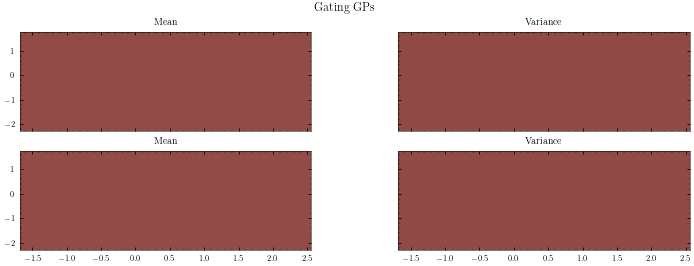

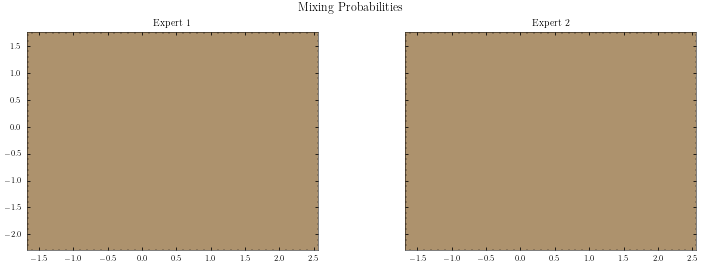

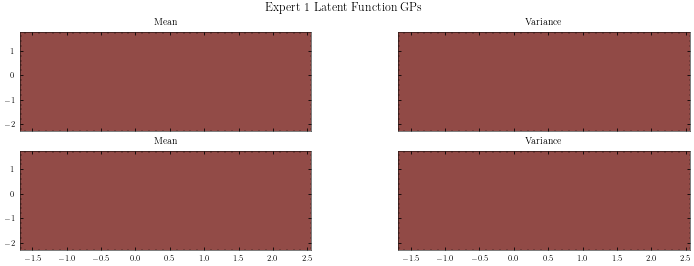

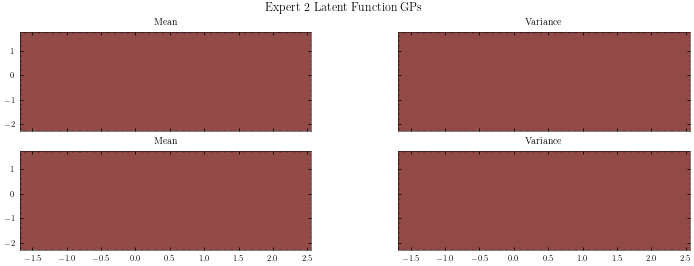

In [19]:
# plotter = QuadcopterPlotter(model, X, Y)
# plotter.plot_model(save_dir="./images")
plot_model(model)

Keras makes training/checkpointing/saving/loading the model super easy! This is the main reason I wanted to use keras. We first configure the training/logging parameters. We will use the Adam optimizer to train the model with SGD. Let's now specify the relevant training parameters.

In [28]:
class PlottingCallback(tf.keras.callbacks.Callback):
    logging_epoch_freq: int = 10
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch % self.logging_epoch_freq == 0:
            plot_model(self.model)
            plt.show()

In [29]:
num_epochs = 5000
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
ckpt_dir = "./ckpts"
log_dir = "./logs"

We can easily use keras callbacks to monitor the model in TensorBorad and checkpoint the model during training.

In [30]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer)

Epoch 1/5000
Mixing probs: (1, 16, 2)
Experts probs: (1, 16, 2)
Mixing probs: (1, 16, 2)
Experts probs: (1, 16, 2)
40/40 [==============================] - 10s 5ms/step - loss: -71.6710


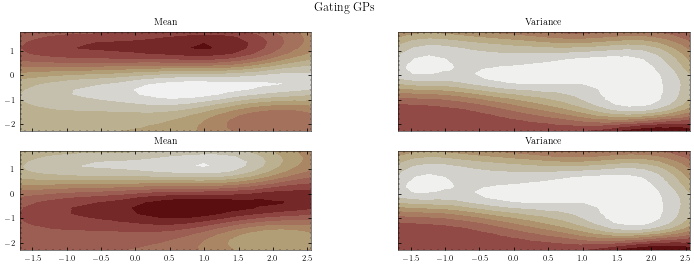

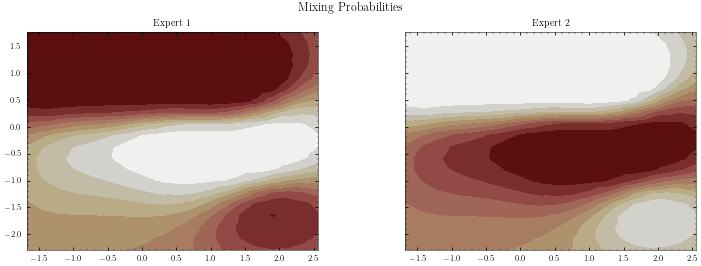

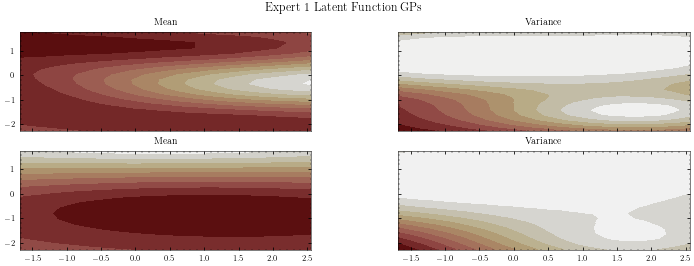

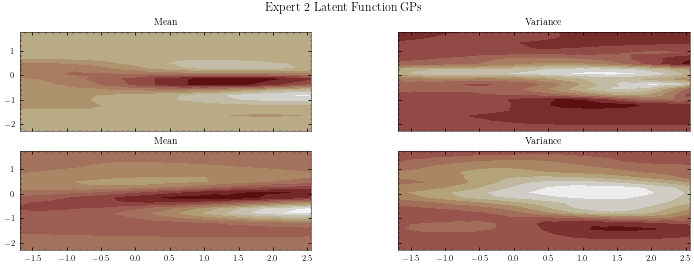

Epoch 2/5000
40/40 [==============================] - 0s 5ms/step - loss: -59.9706
Epoch 3/5000
40/40 [==============================] - 0s 6ms/step - loss: -61.0198
Epoch 4/5000
40/40 [==============================] - 0s 7ms/step - loss: -89.5185
Epoch 5/5000
40/40 [==============================] - 0s 7ms/step - loss: -66.0588
Epoch 6/5000
40/40 [==============================] - 0s 6ms/step - loss: -77.5789
Epoch 7/5000
40/40 [==============================] - 0s 7ms/step - loss: -70.3123
Epoch 8/5000
40/40 [==============================] - 0s 7ms/step - loss: -67.3836
Epoch 9/5000
40/40 [==============================] - 0s 8ms/step - loss: -68.5609
Epoch 10/5000
40/40 [==============================] - 0s 8ms/step - loss: -75.9197
Epoch 11/5000
40/40 [==============================] - 0s 8ms/step - loss: -82.6045


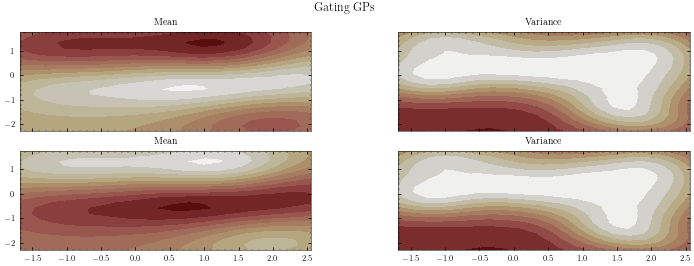

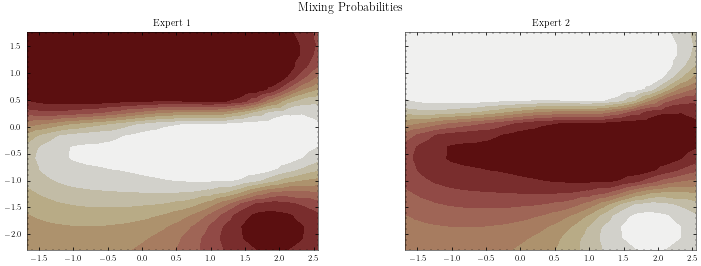

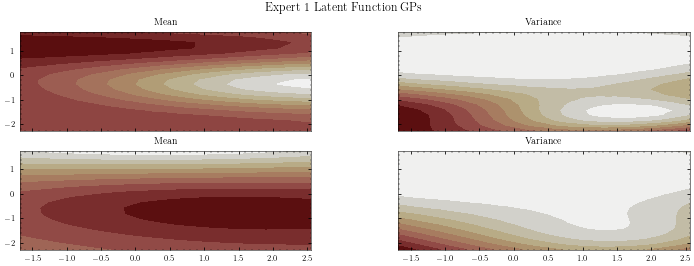

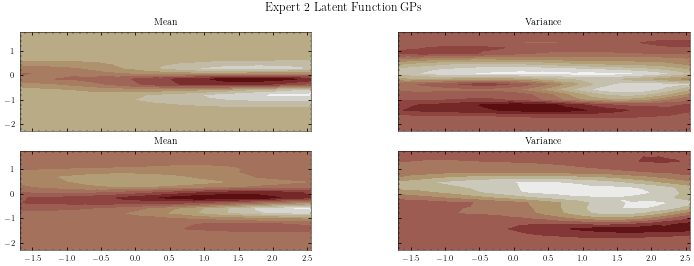

Epoch 12/5000
40/40 [==============================] - 0s 7ms/step - loss: -81.4362
Epoch 13/5000
40/40 [==============================] - 0s 6ms/step - loss: -62.7455
Epoch 14/5000
40/40 [==============================] - 0s 7ms/step - loss: -74.8143
Epoch 15/5000
40/40 [==============================] - 0s 7ms/step - loss: -85.6244
Epoch 16/5000
40/40 [==============================] - 0s 7ms/step - loss: -53.9856
Epoch 17/5000
40/40 [==============================] - 0s 7ms/step - loss: -87.9969
Epoch 18/5000
40/40 [==============================] - 0s 7ms/step - loss: -74.4543
Epoch 19/5000
40/40 [==============================] - 0s 7ms/step - loss: -76.7650
Epoch 20/5000
40/40 [==============================] - 0s 7ms/step - loss: -79.2626
Epoch 21/5000
40/40 [==============================] - 0s 7ms/step - loss: -72.9521


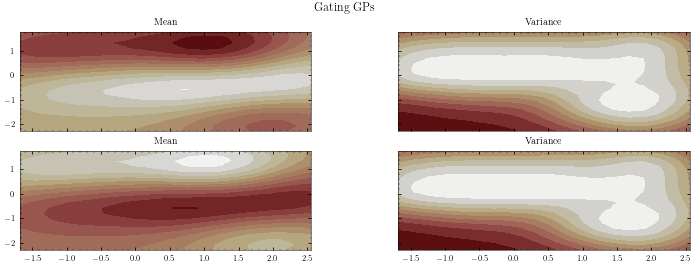

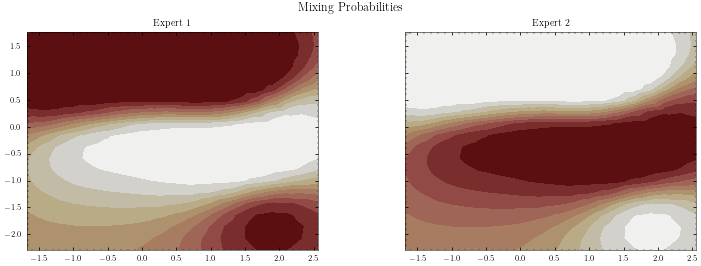

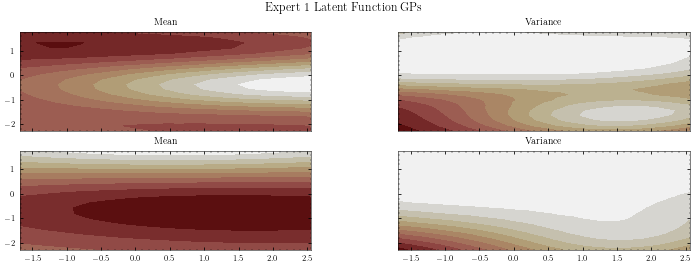

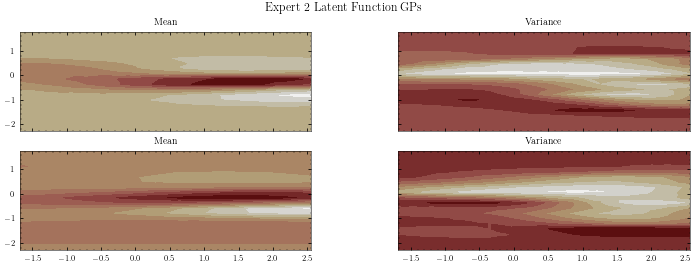

Epoch 22/5000
40/40 [==============================] - 0s 8ms/step - loss: -91.4548
Epoch 23/5000
40/40 [==============================] - 0s 7ms/step - loss: -70.6144
Epoch 24/5000
40/40 [==============================] - 0s 7ms/step - loss: -79.4658
Epoch 25/5000
40/40 [==============================] - 0s 8ms/step - loss: -83.3647
Epoch 26/5000
40/40 [==============================] - 0s 8ms/step - loss: -75.3661
Epoch 27/5000
40/40 [==============================] - 0s 8ms/step - loss: -85.8109
Epoch 28/5000
40/40 [==============================] - 0s 8ms/step - loss: -75.4403
Epoch 29/5000
40/40 [==============================] - 0s 9ms/step - loss: -75.1008
Epoch 30/5000
40/40 [==============================] - 0s 9ms/step - loss: -89.7994
Epoch 31/5000
40/40 [==============================] - 0s 9ms/step - loss: -61.3358


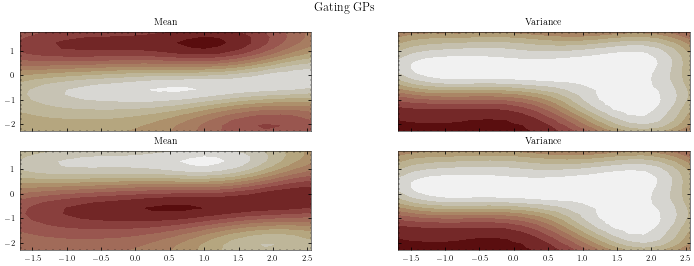

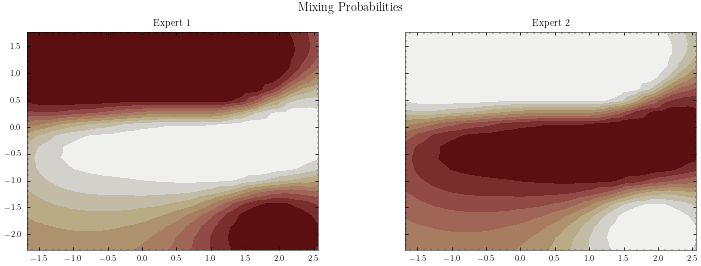

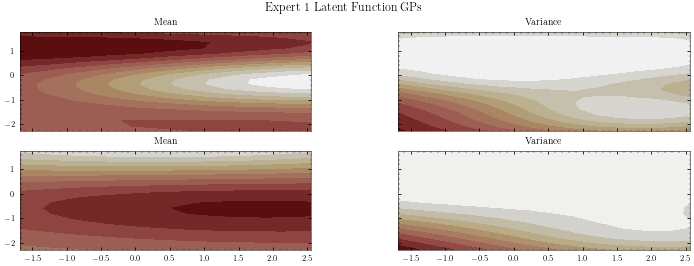

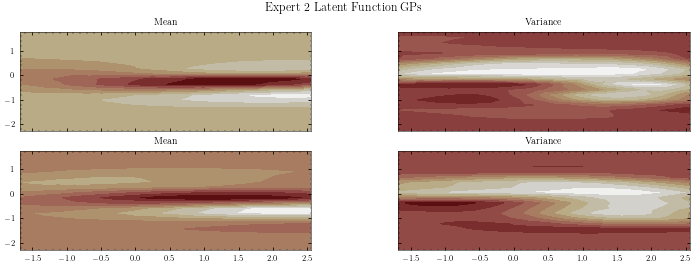

Epoch 32/5000
40/40 [==============================] - 0s 9ms/step - loss: -98.4246
Epoch 33/5000
40/40 [==============================] - 0s 8ms/step - loss: -70.2923
Epoch 34/5000
40/40 [==============================] - 0s 9ms/step - loss: -79.6769
Epoch 35/5000
40/40 [==============================] - 0s 9ms/step - loss: -87.6252
Epoch 36/5000
40/40 [==============================] - 0s 8ms/step - loss: -69.0369
Epoch 37/5000
40/40 [==============================] - 0s 8ms/step - loss: -81.4278
Epoch 38/5000
40/40 [==============================] - 0s 8ms/step - loss: -79.0209
Epoch 39/5000
40/40 [==============================] - 0s 8ms/step - loss: -84.0718
Epoch 40/5000
40/40 [==============================] - 0s 9ms/step - loss: -85.3794
Epoch 41/5000
40/40 [==============================] - 0s 9ms/step - loss: -79.1587


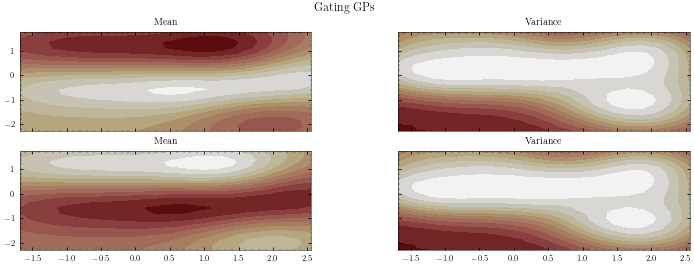

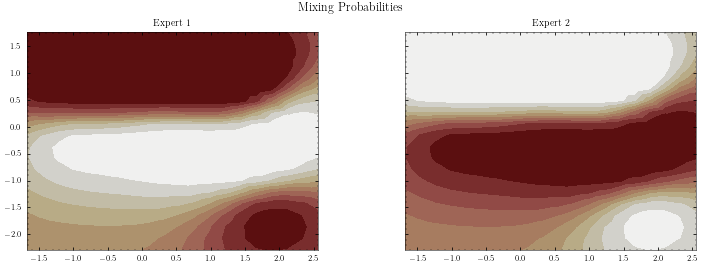

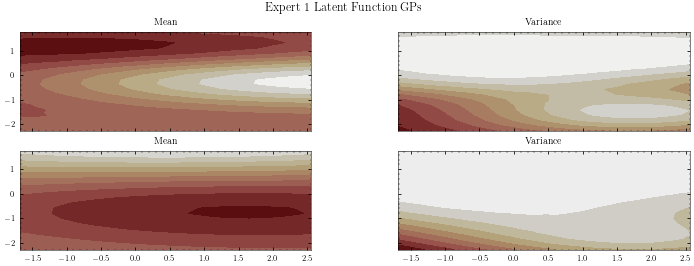

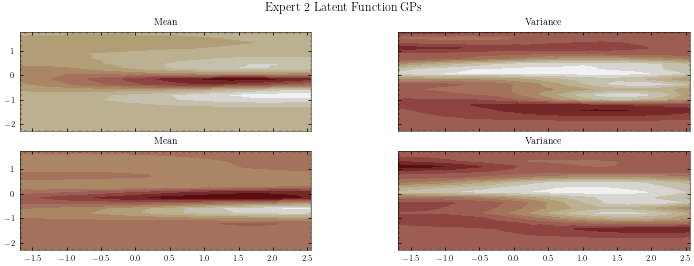

Epoch 42/5000
40/40 [==============================] - 0s 10ms/step - loss: -81.5758
Epoch 43/5000
40/40 [==============================] - 0s 10ms/step - loss: -68.1311
Epoch 44/5000
40/40 [==============================] - 0s 10ms/step - loss: -103.8697
Epoch 45/5000
40/40 [==============================] - 0s 9ms/step - loss: -81.0968
Epoch 46/5000
40/40 [==============================] - 0s 10ms/step - loss: -90.7409
Epoch 47/5000
40/40 [==============================] - 0s 10ms/step - loss: -81.0448
Epoch 48/5000
40/40 [==============================] - 0s 10ms/step - loss: -88.6463
Epoch 49/5000
40/40 [==============================] - 0s 11ms/step - loss: -98.4694
Epoch 50/5000
40/40 [==============================] - 0s 11ms/step - loss: -66.9481
Epoch 51/5000
40/40 [==============================] - 0s 11ms/step - loss: -81.2540


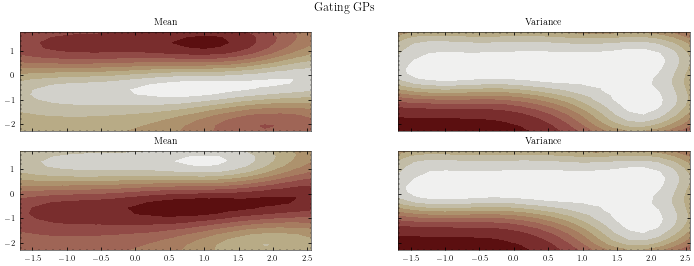

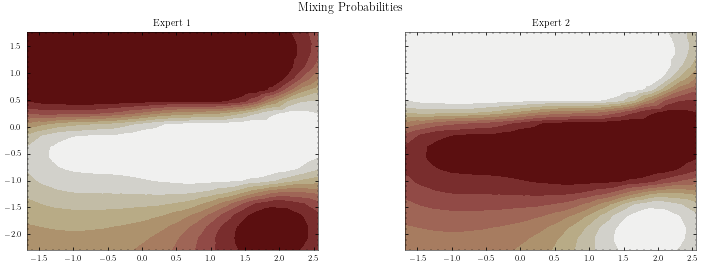

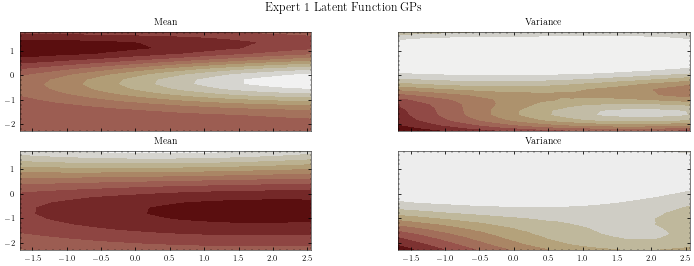

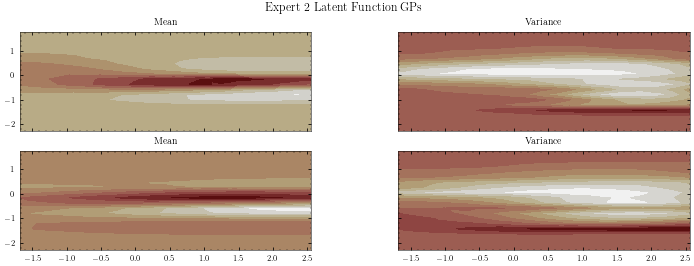

Epoch 52/5000
40/40 [==============================] - 0s 10ms/step - loss: -86.1085
Epoch 53/5000
40/40 [==============================] - 0s 9ms/step - loss: -91.1287
Epoch 54/5000
40/40 [==============================] - 0s 10ms/step - loss: -87.4248
Epoch 55/5000
40/40 [==============================] - 0s 10ms/step - loss: -85.7585
Epoch 56/5000
40/40 [==============================] - 0s 10ms/step - loss: -63.3303
Epoch 57/5000
40/40 [==============================] - 0s 10ms/step - loss: -79.6345
Epoch 58/5000
40/40 [==============================] - 0s 11ms/step - loss: -84.6640
Epoch 59/5000
40/40 [==============================] - 0s 10ms/step - loss: -63.2688
Epoch 60/5000
40/40 [==============================] - 0s 11ms/step - loss: -88.4303
Epoch 61/5000
40/40 [==============================] - 0s 11ms/step - loss: -99.8516


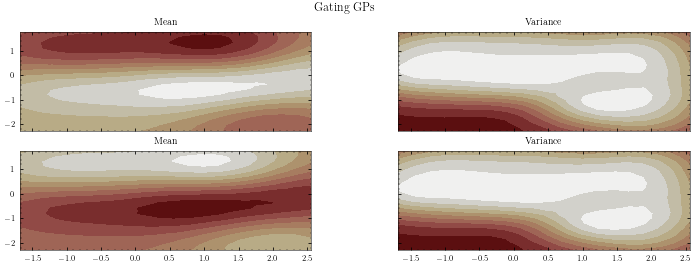

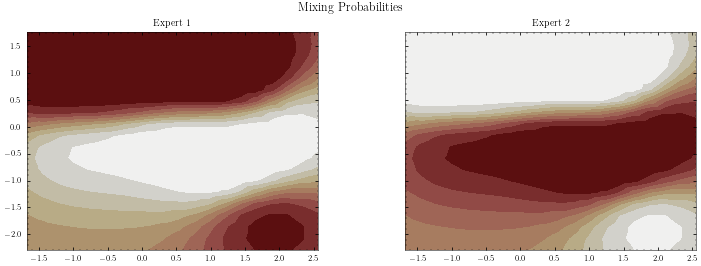

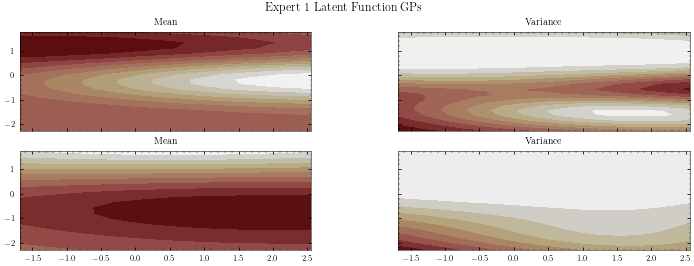

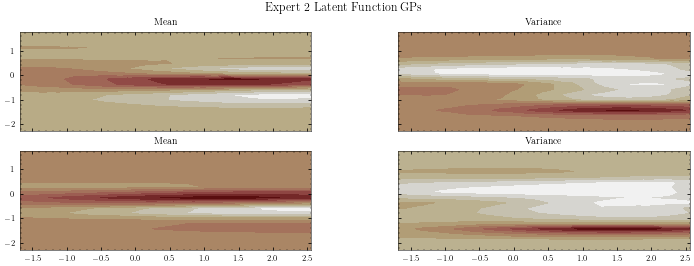

Epoch 62/5000
40/40 [==============================] - 0s 10ms/step - loss: -83.0037
Epoch 63/5000
40/40 [==============================] - 0s 10ms/step - loss: -90.7197
Epoch 64/5000
40/40 [==============================] - 0s 11ms/step - loss: -81.0124
Epoch 65/5000
40/40 [==============================] - 0s 11ms/step - loss: -88.3371
Epoch 66/5000
40/40 [==============================] - 0s 11ms/step - loss: -92.9319
Epoch 67/5000
40/40 [==============================] - 0s 11ms/step - loss: -82.5843
Epoch 68/5000
40/40 [==============================] - 0s 12ms/step - loss: -82.1425
Epoch 69/5000
40/40 [==============================] - 0s 12ms/step - loss: -91.5503
Epoch 70/5000
40/40 [==============================] - 0s 11ms/step - loss: -84.6083
Epoch 71/5000
40/40 [==============================] - 0s 11ms/step - loss: -90.6263


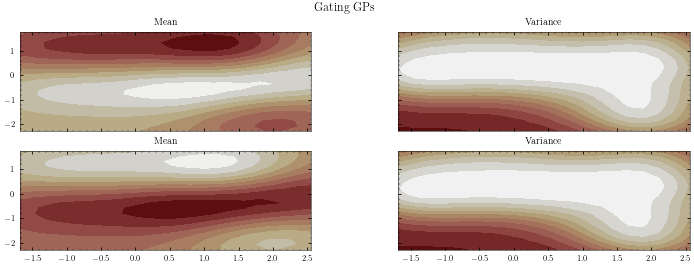

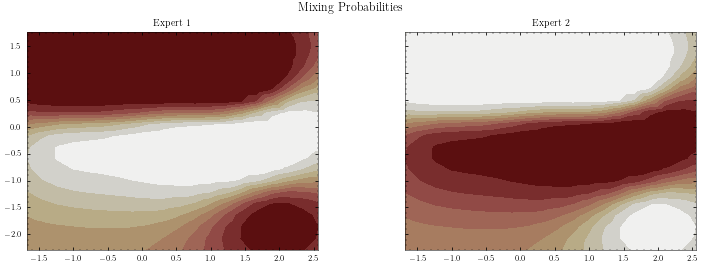

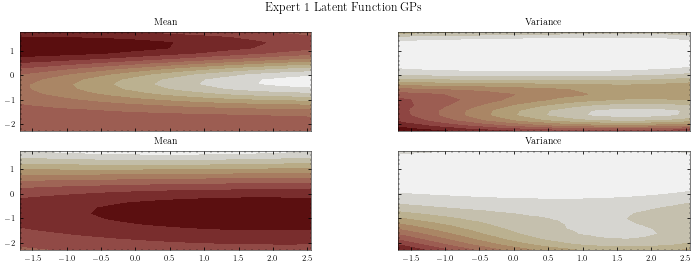

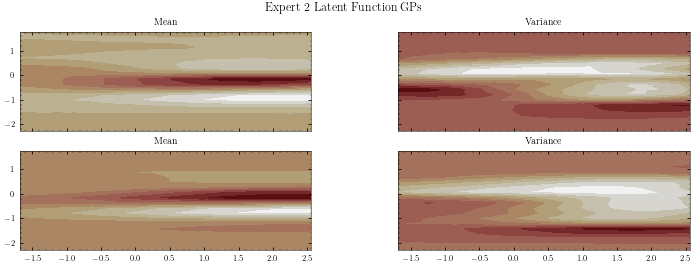

Epoch 72/5000
40/40 [==============================] - 0s 12ms/step - loss: -77.9784
Epoch 73/5000
40/40 [==============================] - 0s 12ms/step - loss: -94.3847
Epoch 74/5000
40/40 [==============================] - 0s 12ms/step - loss: -85.2797
Epoch 75/5000
40/40 [==============================] - 0s 12ms/step - loss: -100.4594
Epoch 76/5000
40/40 [==============================] - 0s 11ms/step - loss: -78.0828
Epoch 77/5000
40/40 [==============================] - 0s 11ms/step - loss: -82.5860
Epoch 78/5000
40/40 [==============================] - 0s 11ms/step - loss: -91.4606
Epoch 79/5000
40/40 [==============================] - 0s 11ms/step - loss: -97.1851
Epoch 80/5000
40/40 [==============================] - 0s 11ms/step - loss: -79.5269
Epoch 81/5000
40/40 [==============================] - 0s 11ms/step - loss: -75.2973


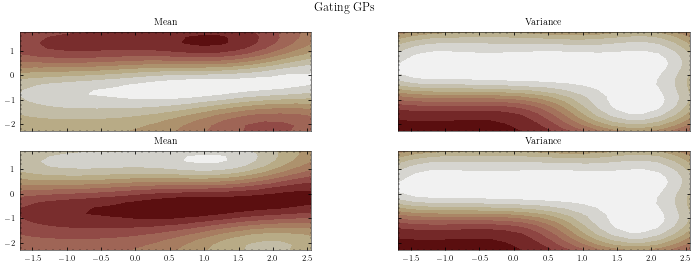

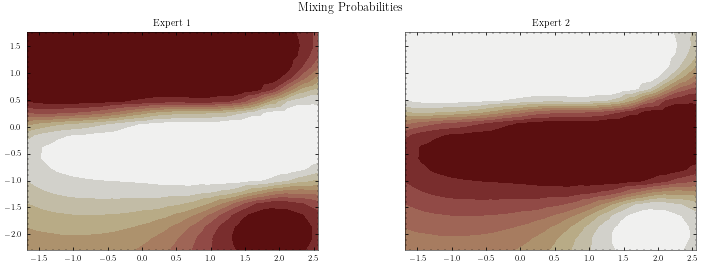

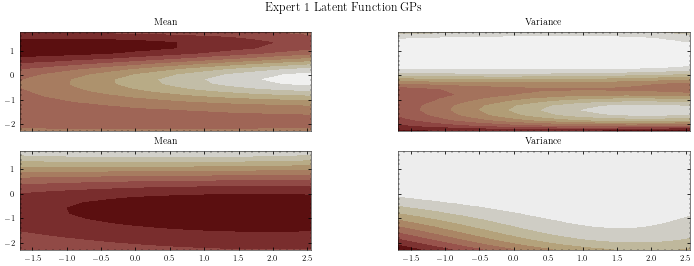

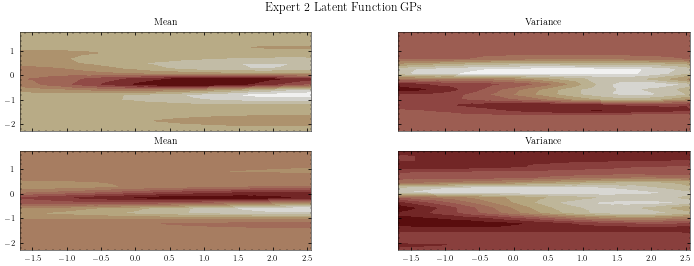

Epoch 82/5000
40/40 [==============================] - 0s 12ms/step - loss: -82.8498
Epoch 83/5000
40/40 [==============================] - 0s 12ms/step - loss: -79.3039
Epoch 84/5000
40/40 [==============================] - 0s 11ms/step - loss: -79.3638
Epoch 85/5000
40/40 [==============================] - 0s 11ms/step - loss: -95.4948
Epoch 86/5000
40/40 [==============================] - 0s 11ms/step - loss: -87.1816
Epoch 87/5000
40/40 [==============================] - 0s 11ms/step - loss: -88.6277
Epoch 88/5000
40/40 [==============================] - 0s 10ms/step - loss: -71.4310
Epoch 89/5000
40/40 [==============================] - 0s 11ms/step - loss: -92.3521
Epoch 90/5000
40/40 [==============================] - 0s 11ms/step - loss: -78.3971
Epoch 91/5000
40/40 [==============================] - 0s 11ms/step - loss: -91.3248


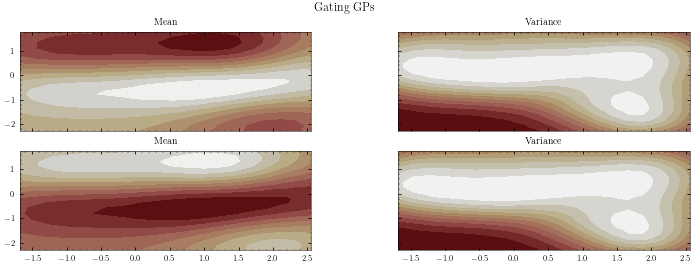

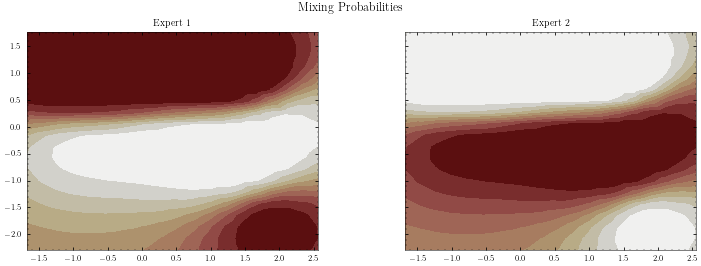

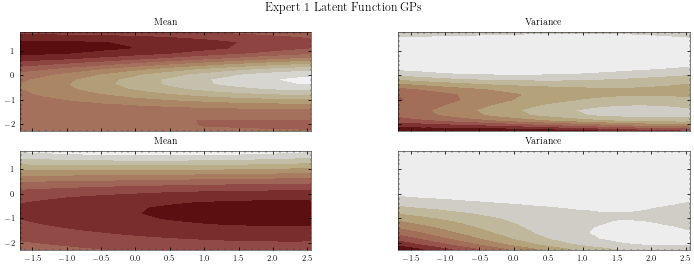

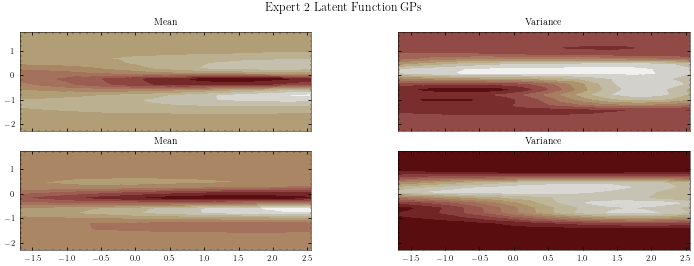

Epoch 92/5000
40/40 [==============================] - 0s 9ms/step - loss: -89.4560
Epoch 93/5000
40/40 [==============================] - 0s 9ms/step - loss: -84.7581
Epoch 94/5000
40/40 [==============================] - 0s 9ms/step - loss: -85.2158
Epoch 95/5000
40/40 [==============================] - 0s 9ms/step - loss: -89.8765
Epoch 96/5000
40/40 [==============================] - 0s 9ms/step - loss: -76.0739
Epoch 97/5000
40/40 [==============================] - 0s 9ms/step - loss: -81.5176
Epoch 98/5000
40/40 [==============================] - 0s 9ms/step - loss: -90.1237
Epoch 99/5000
40/40 [==============================] - 0s 9ms/step - loss: -96.5616
Epoch 100/5000
40/40 [==============================] - 0s 9ms/step - loss: -86.5261
Epoch 101/5000
40/40 [==============================] - 0s 9ms/step - loss: -75.5563


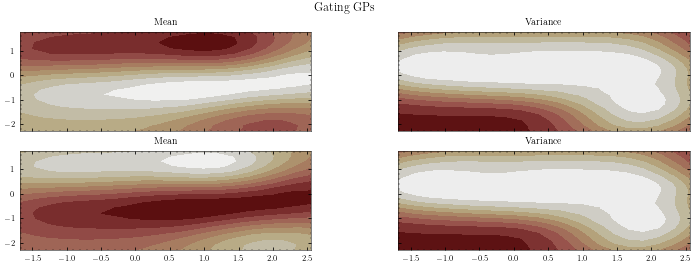

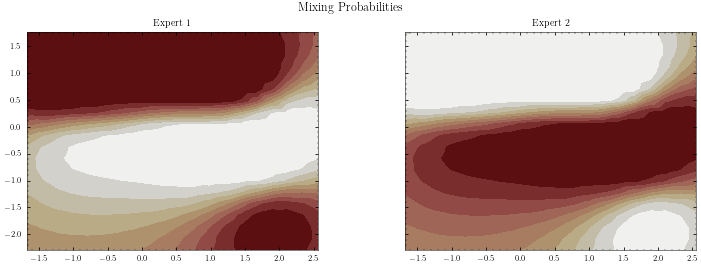

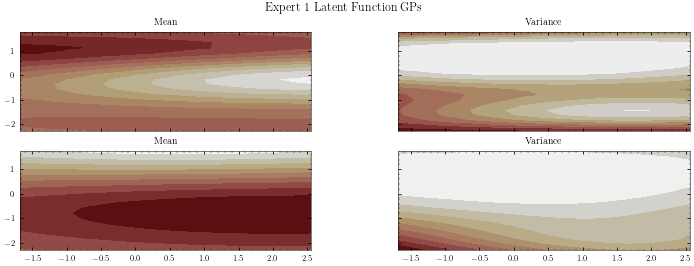

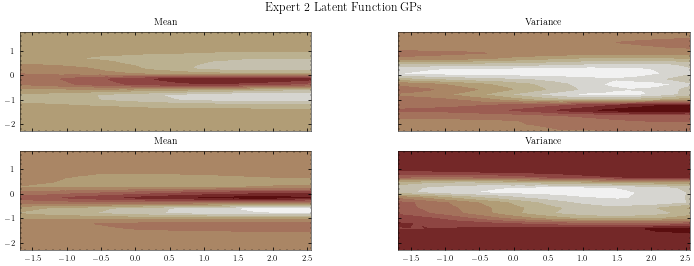

Epoch 102/5000
40/40 [==============================] - 0s 9ms/step - loss: -81.4768
Epoch 103/5000
40/40 [==============================] - 0s 8ms/step - loss: -80.8049
Epoch 104/5000
40/40 [==============================] - 0s 8ms/step - loss: -81.1992
Epoch 105/5000
40/40 [==============================] - 0s 8ms/step - loss: -99.7649
Epoch 106/5000
40/40 [==============================] - 0s 8ms/step - loss: -99.0764
Epoch 107/5000
40/40 [==============================] - 0s 8ms/step - loss: -92.1321
Epoch 108/5000
40/40 [==============================] - 0s 8ms/step - loss: -91.8672
Epoch 109/5000
40/40 [==============================] - 0s 8ms/step - loss: -112.3936
Epoch 110/5000
40/40 [==============================] - 0s 8ms/step - loss: -76.8376
Epoch 111/5000
40/40 [==============================] - 0s 8ms/step - loss: -99.1202


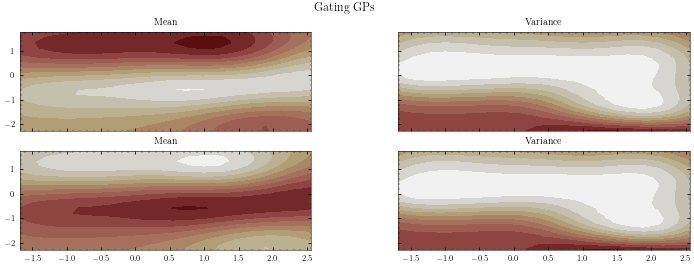

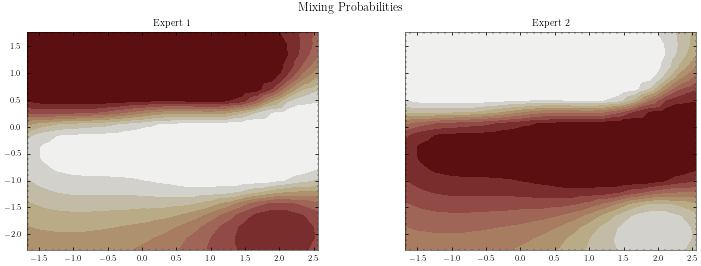

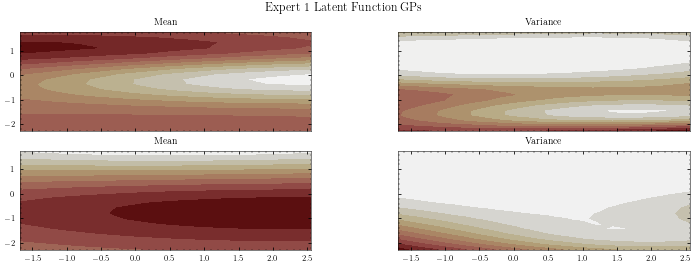

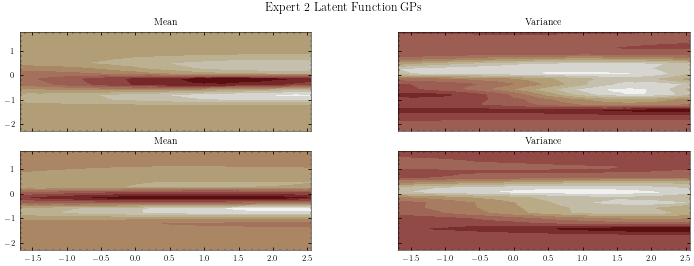

Epoch 112/5000
40/40 [==============================] - 0s 8ms/step - loss: -101.6684
Epoch 113/5000
40/40 [==============================] - 0s 8ms/step - loss: -87.6348
Epoch 114/5000
40/40 [==============================] - 0s 8ms/step - loss: -84.5458
Epoch 115/5000
40/40 [==============================] - 0s 8ms/step - loss: -106.9002
Epoch 116/5000
40/40 [==============================] - 0s 8ms/step - loss: -81.0978
Epoch 117/5000
40/40 [==============================] - 0s 9ms/step - loss: -92.7626
Epoch 118/5000
40/40 [==============================] - 0s 9ms/step - loss: -67.4628
Epoch 119/5000
40/40 [==============================] - 0s 10ms/step - loss: -92.9059
Epoch 120/5000
35/40 [=========================>....] - ETA: 0s - loss: -91.1857 


KeyboardInterrupt



In [31]:
# history = model.fit(X, Y, epochs=num_epochs, batch_size=batch_size)
history = model.fit(X, Y, epochs=num_epochs, batch_size=batch_size, callbacks=[PlottingCallback(logging_epoch_freq=100)])

In [ ]:
def plot_elbo(negative_elbo):
    plt.subplot(111)
    plt.scatter(np.arange(len(negative_elbo)), negative_elbo)
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO")
plot_elbo(history.history["loss"])
# print_summary(expert, fmt="notebook")

Now that we have trained the model we can use our plotter again to visualise what we have learned.

In [ ]:
plot_model(model)

## Saving/Loading

The model can easily be saved using keras as I have implemented the `get_config`/`from_config` methods for all components of the model (including some GPflow kernels/mean_functions/likelihoods/inducing_variables). Let's save the model...

In [ ]:
save_dir = "./saved_models/two_experts"
model(X)
model.save(save_dir)

The saved model can then be loaded in multiple ways using Keras,
1. Load the saved model with its `call` method but no other attributes/methods. This can get you out of tricky situations, when the code base has changed and keras cannot instantiate the model using the `get_config`/`from_config` methods. The model can still make predictions but it is not a instance of its original class so does not have its attributes and methods, just its `call` function.
2. Instantiate the models class using the saved config files.

Option 2 is preferred. Let's now demonstrate both approaches.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)
np.testing.assert_allclose(loaded_model(X[0:15, :]), model(X[0:15, :]))
print(type(loaded_model))

In this case `loaded_model` is not instance of `MixtureOfSVGPExpert` so `plot_model()` will fail because it tries to acess `MixtureOfSVGPExperts` attributes.

In [ ]:
plot_model(loaded_model)

Alternatively, the saved model can be used to create an instance of `MixtureOfSVGPExperts` using the following.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})
np.testing.assert_allclose(loaded_model(X), model(X))
print(type(loaded_model))

`loaded_model` is now an instance of `MixtureOfSVGPExpert` so all of its attributes and methods can be called. Let's plot the model to check that they are actually there!

In [ ]:
plot_model(loaded_model)

## YAML configuration

It is also convenient to instantiate models from YAML config files. I have setup the `get_config`/`from_config` methods to instantiate classes with their defaults values if they are not supplied (note that non optional arguments must be set). Further to this, specifying large arrays, e.g. `q_mu`/`q_sqrt`/`Z`, is not very user friendly... 
I have enabled the inducing_inputs (inducing_variable.Z) to be set by specifying the number of inducing points and the input dimensionality. The YAML config looks as follows:
```
inducing_variable:
  class_name: InducingPoints
  config:
    num_inducing: 10
    input_dim: 1
```

In [5]:
yaml_cfg_filename = "./keras_configs/two_experts.yaml"
model_from_cfg = model_from_yaml(yaml_cfg_filename, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})
print_summary(model_from_cfg, fmt='notebook')

{'class_name': 'MixtureOfSVGPExperts', 'config': {'experts_list': [{'class_name': 'SVGPExpert', 'config': {'kernel': {'class_name': 'SeparateIndependent', 'config': {'kernels': [{'class_name': 'SquaredExponential', 'config': {'lengthscales': [1.0, 1.0], 'variance': 1.0}}, {'class_name': 'SquaredExponential', 'config': {'lengthscales': [1.0, 1.0], 'variance': 1.0}}]}}, 'likelihood': {'class_name': 'Gaussian', 'config': {'variance': [1.0, 1.0]}}, 'mean_function': {'class_name': 'Constant', 'config': {'c': [0.0, 0.0]}}, 'inducing_variable': {'class_name': 'SharedIndependentInducingVariables', 'config': {'inducing_variable': {'class_name': 'InducingPoints', 'config': {'num_inducing': 90, 'input_dim': 2}}}}, 'num_latent_gps': 2}}, {'class_name': 'SVGPExpert', 'config': {'kernel': {'class_name': 'SeparateIndependent', 'config': {'kernels': [{'class_name': 'SquaredExponential', 'config': {'lengthscales': [1.0, 1.0], 'variance': 1.0}}, {'class_name': 'SquaredExponential', 'config': {'lengthsca

2022-02-16 11:06:12.983778: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


name,class,transform,prior,trainable,shape,dtype,value
MixtureOfSVGPExperts._metrics[0]._non_trainable_weights[0] MixtureOfSVGPExperts._metrics[0].total MixtureOfSVGPExperts._self_tracked_trackables[2]._non_trainable_weights[0] MixtureOfSVGPExperts._self_tracked_trackables[2].total MixtureOfSVGPExperts.loss_tracker._non_trainable_weights[0] MixtureOfSVGPExperts.loss_tracker.total,ResourceVariable,,,False,(),float64,0.0
MixtureOfSVGPExperts._metrics[0]._non_trainable_weights[1] MixtureOfSVGPExperts._metrics[0].count MixtureOfSVGPExperts._self_tracked_trackables[2]._non_trainable_weights[1] MixtureOfSVGPExperts._self_tracked_trackables[2].count MixtureOfSVGPExperts.loss_tracker._non_trainable_weights[1] MixtureOfSVGPExperts.loss_tracker.count,ResourceVariable,,,False,(),float64,0.0
MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._gp._trainable_weights[0],ResourceVariable,,,True,"(90, 2)",float64,"[[0., 0...."
MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0]._trainable_weights[1] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp._trainable_weights[1] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0]._trainable_weights[1] MixtureOfSVGPExperts._experts_list[0]._gp._trainable_weights[1],ResourceVariable,,,True,"(2, 4095)",float64,"[[1., 0., 0...."
MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0]._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0].mean_function._trainable_weights[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp.mean_function._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0]._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0].mean_function._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._gp._self_tracked_trackables[0]._trainable_weights[0] MixtureOfSVGPExperts._experts_list[0]._gp.mean_function._trainable_weights[0],ResourceVariable,,,True,"(2,)",float64,[0. 0.]
MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0]._self_tracked_trackables[0]._self_tracked_trackables[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0]._self_tracked_trackables[0].c MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0].mean_function._self_tracked_trackables[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._self_tracked_trackables[0].mean_function.c MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp._self_tracked_trackables[0]._self_tracked_trackables[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp._self_tracked_trackables[0].c MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp.mean_function._self_tracked_trackables[0] MixtureOfSVGPExperts._self_tracked_trackables[0][0]._gp.mean_function.c MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0]._self_tracked_trackables[0]._self_tracked_trackables[0] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0]._self_tracked_trackables[0].c MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0].mean_function._self_tracked_trackables[0] MixtureOfSVGPExperts._experts_list[0]._self_tracked_trackables[0].mean_function.c MixtureOfSVGPExperts._experts_list[0]._gp._self_tracked_trackables[0]._self_tracked_trackables[0] MixtureOfSVGPExperts._experts_list[0]._gp._self_tracked_trackables[0].c MixtureOfSVGPExperts._experts_list[0]._gp.mean_function._self_tracked_trackables[0] MixtureOfSVGPExperts._experts_list[0]._gp.mean_functio

In [6]:
model_from_cfg(X)
# print(model_from_cfg.gating_network.gp.inducing_variable.Z)
# print(model_from_cfg.experts_list[0].gp.inducing_variable.inducing_variable.Z)
# model_from_cfg.summary()

tfp.distributions.Categorical("MoSVGPE_gp_gating_network_ExpertIndicatorCategorical", batch_shape=[640], event_shape=[], dtype=int32)
(640, 2)
<class 'tensorflow_probability.python.distributions.categorical.Categorical'>


(<tf.Tensor: shape=(640, 2), dtype=float64, numpy=
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])>,
 <tf.Tensor: shape=(640, 2), dtype=float64, numpy=
 array([[1.12354268e+09, 1.12354268e+09],
        [1.00011678e+09, 1.00011678e+09],
        [9.50899084e+08, 9.50899084e+08],
        ...,
        [3.87223661e+07, 3.87223661e+07],
        [3.07641533e+07, 3.07641533e+07],
        [2.65600761e+07, 2.65600761e+07]])>)

In [7]:
def sample_inducing_variables_from_data(X, inducing_variable):
    if isinstance(inducing_variable, gpf.inducing_variables.SharedIndependentInducingVariables):
        inducing_variable.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, inducing_variable.inducing_variable.Z.shape[0]))
    elif isinstance(inducing_variable, gpf.inducing_variables.SeparateIndependentInducingVariables):
        for inducing_var in inducing_variable.inducing_variables:
            Z = sample_mosvgpe_inducing_inputs_from_data(X, inducing_var.Z)
            inducing_var.Z.assign(Z)
    else:
        inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, inducing_variable.Z.shape[0]))
        
def sample_mosvgpe_inducing_inputs_from_data(X, model):
    for expert in  model.experts_list:
        sample_inducing_variables_from_data(X, expert.gp.inducing_variable)
    sample_inducing_variables_from_data(X, model.gating_network.gp.inducing_variable)

# def sample_mosvgpe_inducing_inputs_from_data(X, model):
#     for expert in  model.experts_list:
#         expert.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, expert.gp.inducing_variable.Z.shape[0]))
#     model.gating_network.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, model.gating_network.gp.inducing_variable.Z.shape[0]))
    
sample_mosvgpe_inducing_inputs_from_data(X, model_from_cfg)
# print(model_from_cfg.gating_network.gp.inducing_variable.Z)
# print(model_from_cfg.experts_list[0].gp.inducing_variable.inducing_variable.Z)

NameError: name 'sample_inducing_inputs_from_data' is not defined

In [ ]:
num_epochs = 50
batch_size = 32
learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_from_cfg.compile(optimizer=optimizer)

In [ ]:
history = model_from_cfg.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

In [ ]:
plot_elbo(history.history["loss"])

Now that we have trained the model we can use our plotter again to visualise what we have learned.

In [ ]:
plot_model(model_from_cfg)

## Three Experts
Let's now instantiate the model with three experts and three gating functions. In this setting, the gating network uses the `Softmax` likelihood to obtain the mixing probabilities.

In [ ]:
num_experts = 3
num_inducing_gating = 10
num_inducing_expert = 10
experts_lengthscales = [10.0, 1.0, 10.0]  # lengthsales for expert 1 and 2
three_experts_list = [init_expert(experts_lengthscales[k]) for k in range(num_experts)]
three_gating_network = init_gating_network(num_gating_gps=num_experts)
model_three_experts = MixtureOfSVGPExperts(experts_list=three_experts_list, gating_network=three_gating_network)

Let's visualise our `MixtureOfSVGPExperts` with three experts and three gating functions.

In [ ]:
plot_model(model_three_experts)

In [ ]:
num_epochs = 3000
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
# ckpt_dir = "./ckpts"
# log_dir = "./logs"

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_three_experts.compile(optimizer=optimizer)

In [ ]:
# history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

In [ ]:
plot_model(model_three_experts)